In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns


Tamaño de X_augmented: (27030, 90, 90, 3), Tamaño de y_augmented: 27030


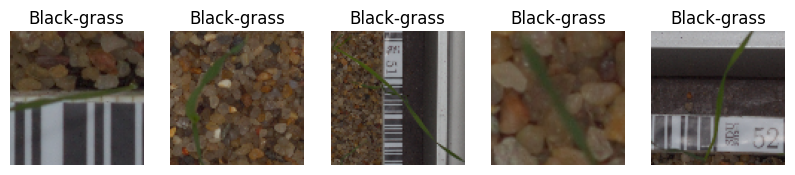

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import glob

# Definición de constantes
IMAGE_SIZE = (90, 90
              )  # Tamaño estándar para muchos modelos de CNN
NUM_CLASSES = 16  # Actualiza según tu conjunto de datos específico

# Función para cargar y preprocesar imágenes
def load_and_preprocess_images(image_paths, label_encoder=None):
    images = []
    labels = []
    
    for path in image_paths:
        # Extraer etiqueta del path
        label = path.split(os.path.sep)[-2]
        
        # Leer imagen
        img = cv2.imread(path)
        img = cv2.resize(img, IMAGE_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Normalizar valores de píxeles
        img = img / 255.0
        
        images.append(img)
        labels.append(label)
    
    # Codificar etiquetas
    if label_encoder is None:
        label_encoder = LabelEncoder()
        labels = label_encoder.fit_transform(labels)
    else:
        labels = label_encoder.transform(labels)
    
    return np.array(images), labels, label_encoder

# Función para rotar imágenes
def rotate_images(images, labels, angles):
    rotated_images = []
    rotated_labels = []

    for img, label in zip(images, labels):
        for angle in angles:
            # Rotar imagen
            h, w = img.shape[:2]
            center = (w // 2, h // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            rotated_img = cv2.warpAffine(img, rotation_matrix, (w, h))
            rotated_images.append(rotated_img)
            rotated_labels.append(label)

    return np.array(rotated_images), np.array(rotated_labels)

# Cargar las rutas de las imágenes (modificar según la estructura de tu conjunto de datos)
train_image_paths = glob.glob('../datos/train/**/*.png', recursive=True)

# Preprocesar las imágenes de entrenamiento
X_train, y_train, label_encoder = load_and_preprocess_images(train_image_paths)

# Definir los ángulos para rotar las imágenes
rotation_angles = [0, 90, 180, 270]  # Ángulos en grados

# Rotar las imágenes y obtener nuevas imágenes y etiquetas
X_rotated, y_rotated = rotate_images(X_train, y_train, rotation_angles)

# Combinar las imágenes originales y rotadas
X_augmented = np.concatenate((X_train, X_rotated), axis=0)
y_augmented = np.concatenate((y_train, y_rotated), axis=0)

# Imprimir tamaños del nuevo conjunto de entrenamiento
print(f"Tamaño de X_augmented: {X_augmented.shape}, Tamaño de y_augmented: {len(y_augmented)}")

# Mostrar algunas imágenes aumentadas
num_images_to_show = 5  # Número de imágenes a mostrar
plt.figure(figsize=(10, 10))
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(X_augmented[i])  # Mostrar la imagen procesada
    plt.title(label_encoder.inverse_transform([y_augmented[i]])[0])  # Muestra la etiqueta original
    plt.axis('off')
plt.show()


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_optimized_cnn(input_shape, num_classes, learning_rate):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding = 'same' ,input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.06),

        Conv2D(64, (3, 3), activation='relu', padding = 'same' ,input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.06),

        Conv2D(128, (3, 3), activation='relu', padding = 'same' ,input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.06),

        Flatten(),

        Dense(256, activation='relu'),
        Dropout(0.27),

        Dense(128, activation='relu'),
        Dropout(0.12),
        
        Dense(num_classes, activation='softmax')

       
    ])
    model.summary()
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [518]:
# Load image paths (modify according to your dataset structure)
train_image_paths = glob.glob('../datos/train/**/*.png', recursive=True)

# Preprocess training images
X_train, y_train, label_encoder = load_and_preprocess_images(train_image_paths)
print(f"Tamaño de X_train: {X_train.shape}, Tamaño de y_train: {len(y_train)}")

Tamaño de X_train: (5406, 32, 32, 3), Tamaño de y_train: 5406


In [ ]:
# Load image paths (modify according to your dataset structure)
train_image_paths = glob.glob('../datos/train/**/*.png', recursive=True)

# Preprocess training images
X_train, y_train, label_encoder = load_and_preprocess_imagesM(train_image_paths)
print(f"Tamaño de X_train: {X_train.shape}, Tamaño de y_train: {len(y_train)}")

In [4]:
# Verifica que el número de muestras sea el mismo
print(f"Longitud de X_train: {len(X_train)}, Longitud de y_train: {len(y_train)}")

# Si son iguales, realiza la división
X_train, X_val, y_train, y_val = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)

# Verifica que el número de muestras sea el mismo
print(f"Longitud de X_train: {len(X_train)}, Longitud de y_train: {len(y_train)}")

Longitud de X_train: 5406, Longitud de y_train: 5406
Longitud de X_train: 21624, Longitud de y_train: 21624


In [ ]:
cnn_model = create_optimized_cnn(input_shape=(64, 64, 3), num_classes=len(label_encoder.classes_),learning_rate=0.0013)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 16, 16, 64)       

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

# Definir el callback de EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Entrenar el modelo con EarlyStopping
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_train, y_train),
    epochs=4,
    batch_size=32,
    callbacks=[early_stop]  # Añadir el callback aquí
)


Epoch 1/4
676/676 [==============================] - 145s 214ms/step - loss: 0.2924 - accuracy: 0.8932 - val_loss: 0.1679 - val_accuracy: 0.9368
Epoch 2/4
676/676 [==============================] - 144s 213ms/step - loss: 0.2808 - accuracy: 0.8951 - val_loss: 0.1557 - val_accuracy: 0.9502
Epoch 3/4
676/676 [==============================] - 136s 202ms/step - loss: 0.2649 - accuracy: 0.9013 - val_loss: 0.1527 - val_accuracy: 0.9495
Epoch 4/4
676/676 [==============================] - 139s 205ms/step - loss: 0.2510 - accuracy: 0.9053 - val_loss: 0.1639 - val_accuracy: 0.9430


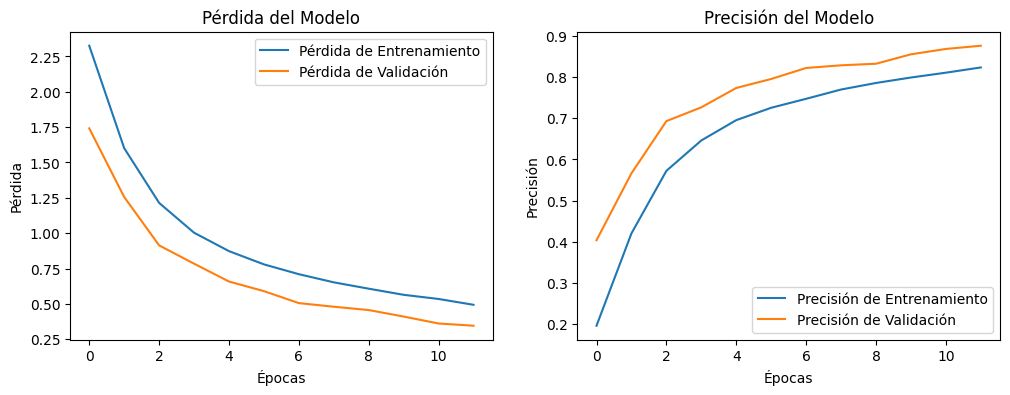

In [25]:
import matplotlib.pyplot as plt

# Graficar la pérdida y precisión del modelo
plt.figure(figsize=(12, 4))

# Gráfica de la pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de la precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()


In [37]:
# Evaluate CNN
cnn_val_loss, cnn_val_accuracy = cnn_model.evaluate(X_val, y_val)
print("CNN Validation Accuracy:", cnn_val_accuracy)

# Confusion Matrix for CNN
cnn_val_pred = cnn_model.predict(X_val)
cnn_val_pred_classes = np.argmax(cnn_val_pred, axis=1)

cnn_cm = confusion_matrix(y_val, cnn_val_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cnn_cm, annot=True, fmt='d', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('cnn_confusion_matrix.png')
plt.close()
    
    

169/169 [==============================] - 7s 39ms/step - loss: 0.3408 - accuracy: 0.8829
CNN Validation Accuracy: 0.8829078674316406
169/169 [==============================] - 6s 34ms/step


In [38]:
import os
import glob
import numpy as np
import pandas as pd

def prepare_submission(model, model_type, label_encoder):
    # Cargar rutas de imágenes de prueba
    test_image_paths = glob.glob('../datos/test/*.png')
    test_images, _, _ = load_and_preprocess_images(test_image_paths, None)  # Se pasa None en lugar del codificador de etiquetas

    # Predicción
    if model_type == 'lr':
        test_pred = model.predict(test_images.reshape(test_images.shape[0], -1))
    else:  # CNN
        test_pred = np.argmax(model.predict(test_images), axis=1)

    # Convertir predicciones al formato original de etiquetas
    test_pred_labels = label_encoder.inverse_transform(test_pred)

    # Crear el DataFrame de resultados
    submission_df = pd.DataFrame({
        'file': [os.path.basename(path) for path in test_image_paths],
        'species': test_pred_labels
    })

    # Asegurarse de que el directorio de resultados exista
    results_dir = '../resultados'
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    # Guardar los resultados
    submission_df.to_csv(f'{results_dir}/{model_type}_submission.csv', index=False)
    print(f"Archivo de resultados guardado como: {model_type}_submission.csv")

# Llamada a la función para crear el archivo de resultados
prepare_submission(cnn_model, 'cnn', label_encoder)


31/31 [==============================] - 1s 37ms/step
Archivo de resultados guardado como: cnn_submission.csv
